In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
sys.path.append('../hovernet')
sys.path.append('../deconvplugin')

import json
import os
import pickle
import torch
import scanpy as sc

PATH = '/home/luca/Documents/data/'

#'/cluster/CBIO/data1/lgortana/'
#'/home/luca/Documents/data/'

/home/luca/anaconda3/envs/plugin-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [2]:
# names
adata_name = 'CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma'
image_dict_name = "6_moco_clusters_12000_cells_image_dict_64.pt"
sim_tag = "6_moco_clusters_700spots_040101010101_15mean_15var"
model_tag = "alpha_0_lr_0.0001_weights_False_divergence_kl_conv_sim_040101010101"

In [3]:
import pandas as pd

data_path = os.path.join(PATH, adata_name)
sim_path = os.path.join(data_path, "sim")

#load image_dict
image_dict = torch.load(os.path.join(sim_path, image_dict_name))

#load ground truth
ground_truth = pd.read_csv(os.path.join(data_path, f'{sim_tag}_gt.csv'), index_col=0)
ground_truth.index = ground_truth.index.astype(str)

In [20]:
#load model infos
model_dir = os.path.join('../models', model_tag)

with open(os.path.join(model_dir, 'info.pickle'), 'rb') as f:
    model_info = pickle.load(f)

In [31]:
from deconvplugin.analysis.pred_analyzer import PredAnalyzer

analyzer = PredAnalyzer(model_info=model_info,
                        model_state="best",
                        adjusted=False,
                        ground_truth=ground_truth, 
                        image_dict=image_dict
                        )

Loading predicted labels...
Loading true labels...
Use `add_attributes(seg_dict=your_seg_dict)` to add one.


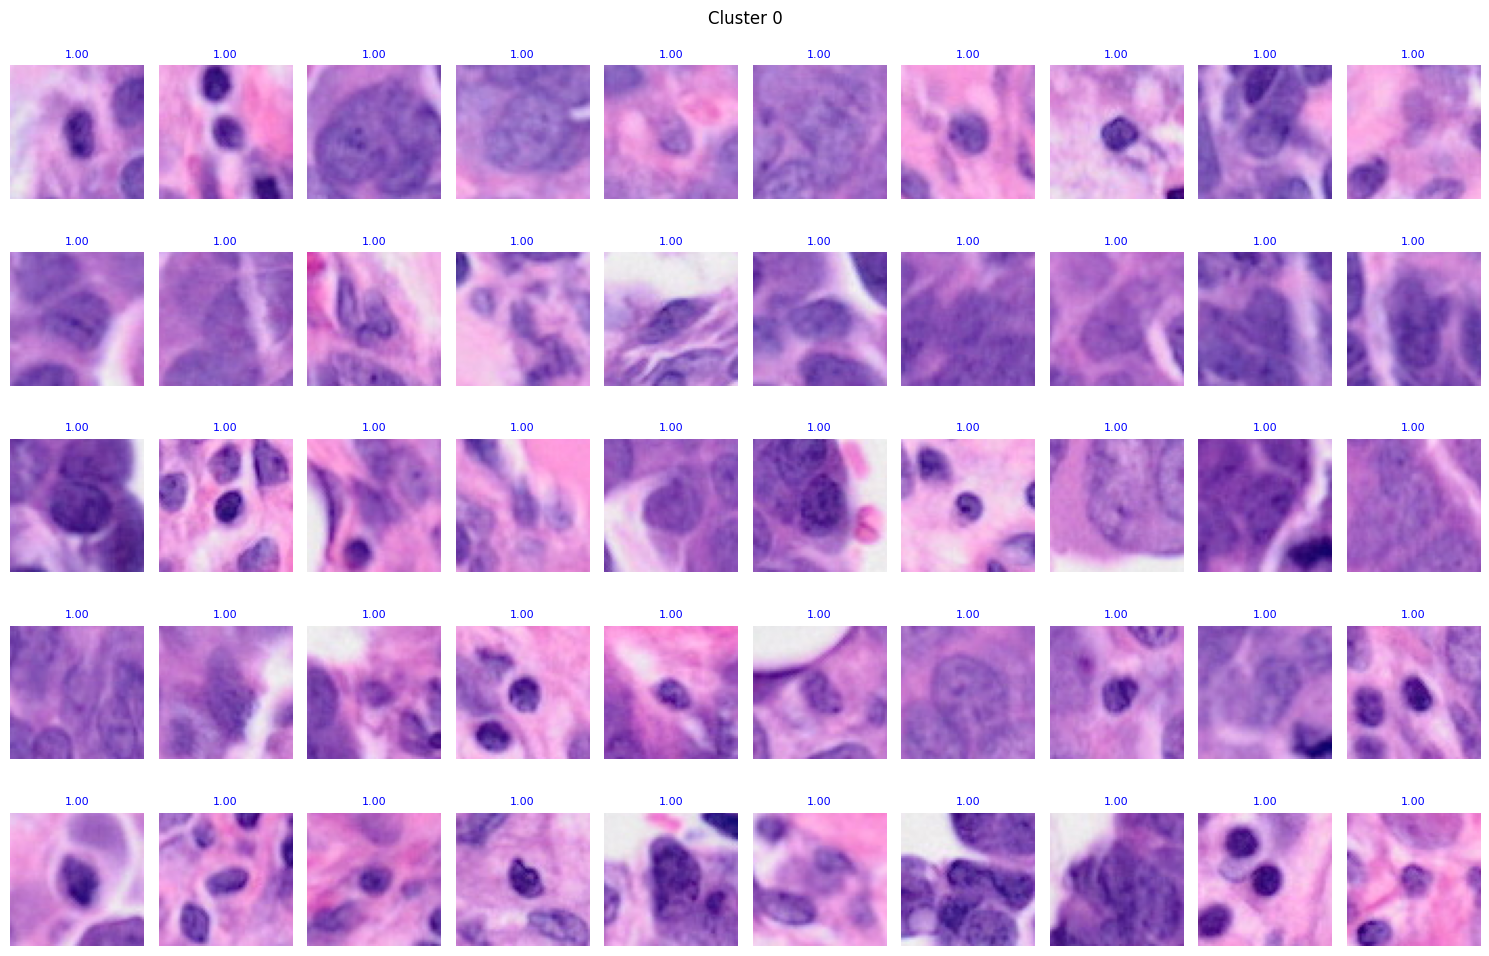

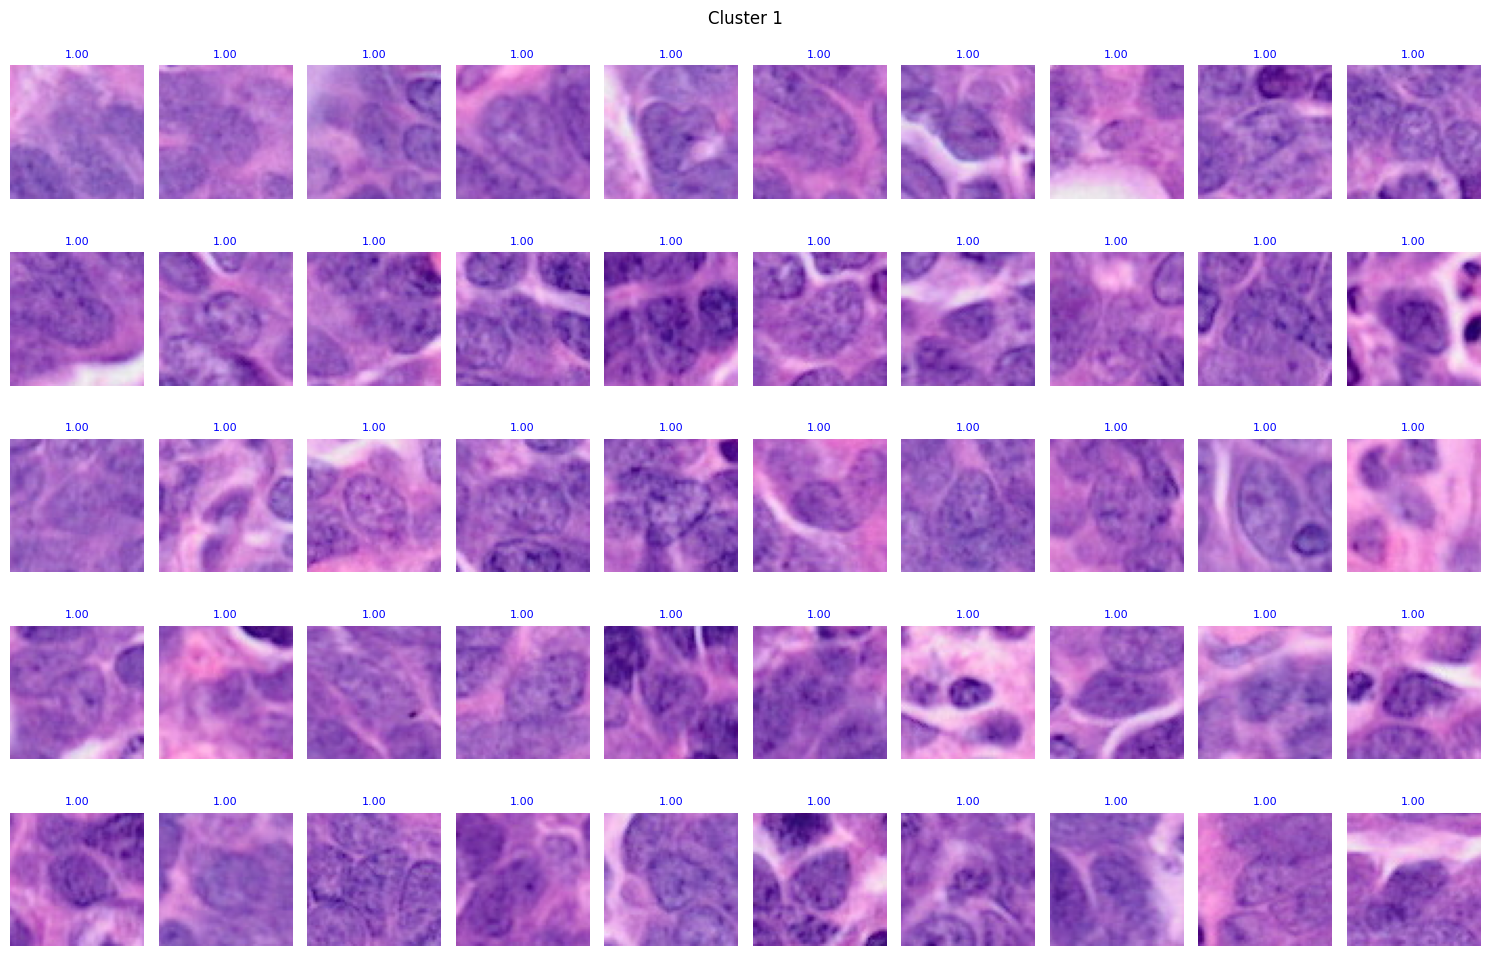

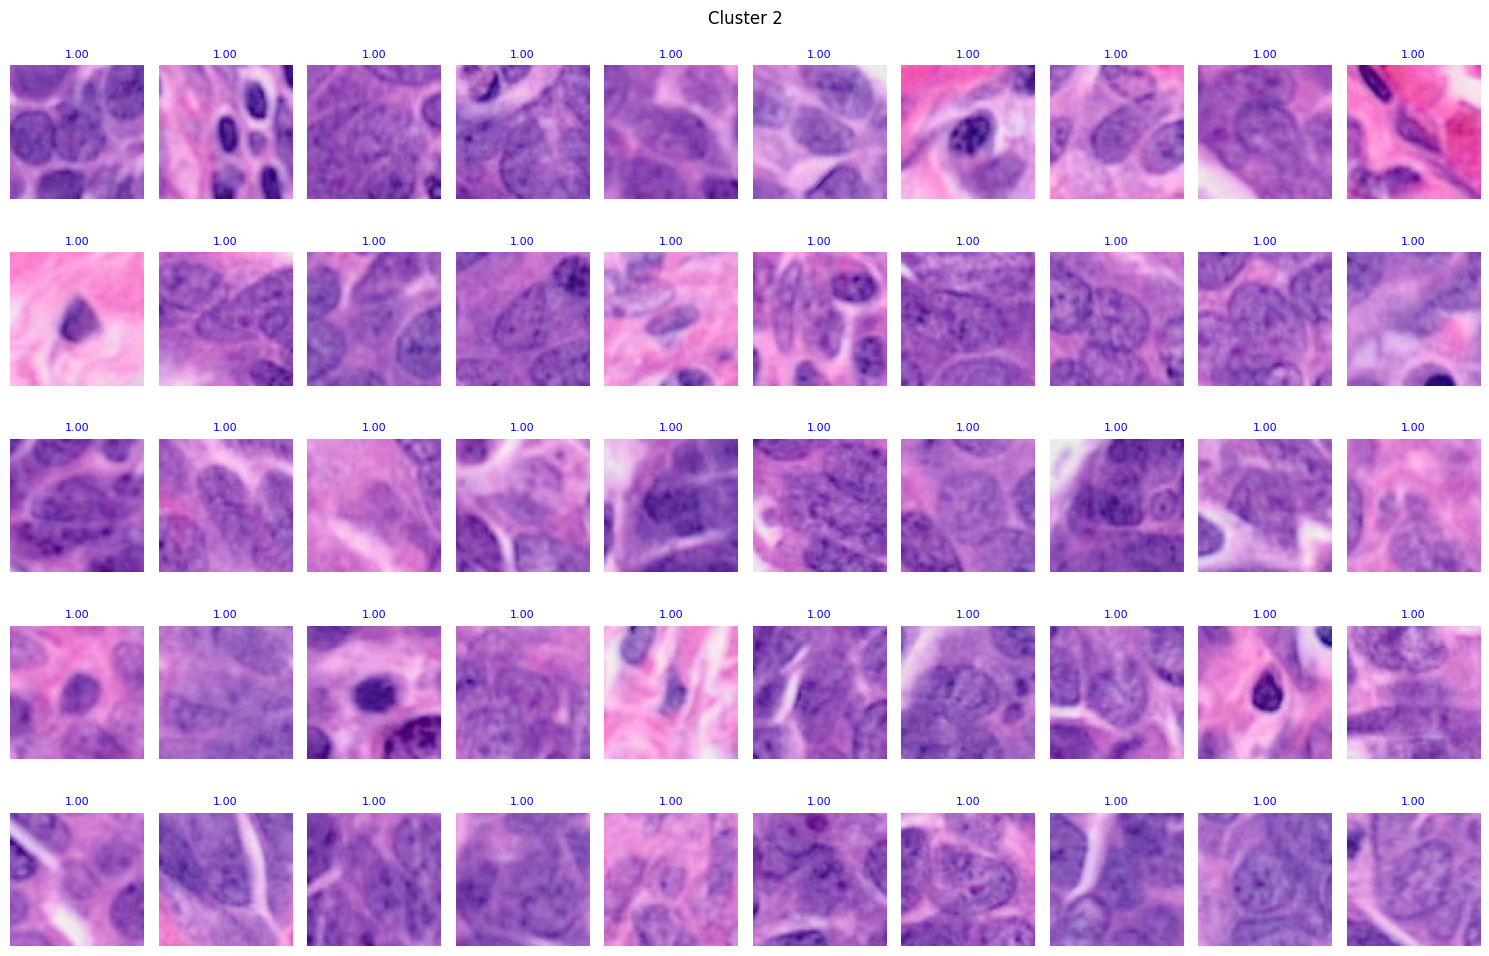

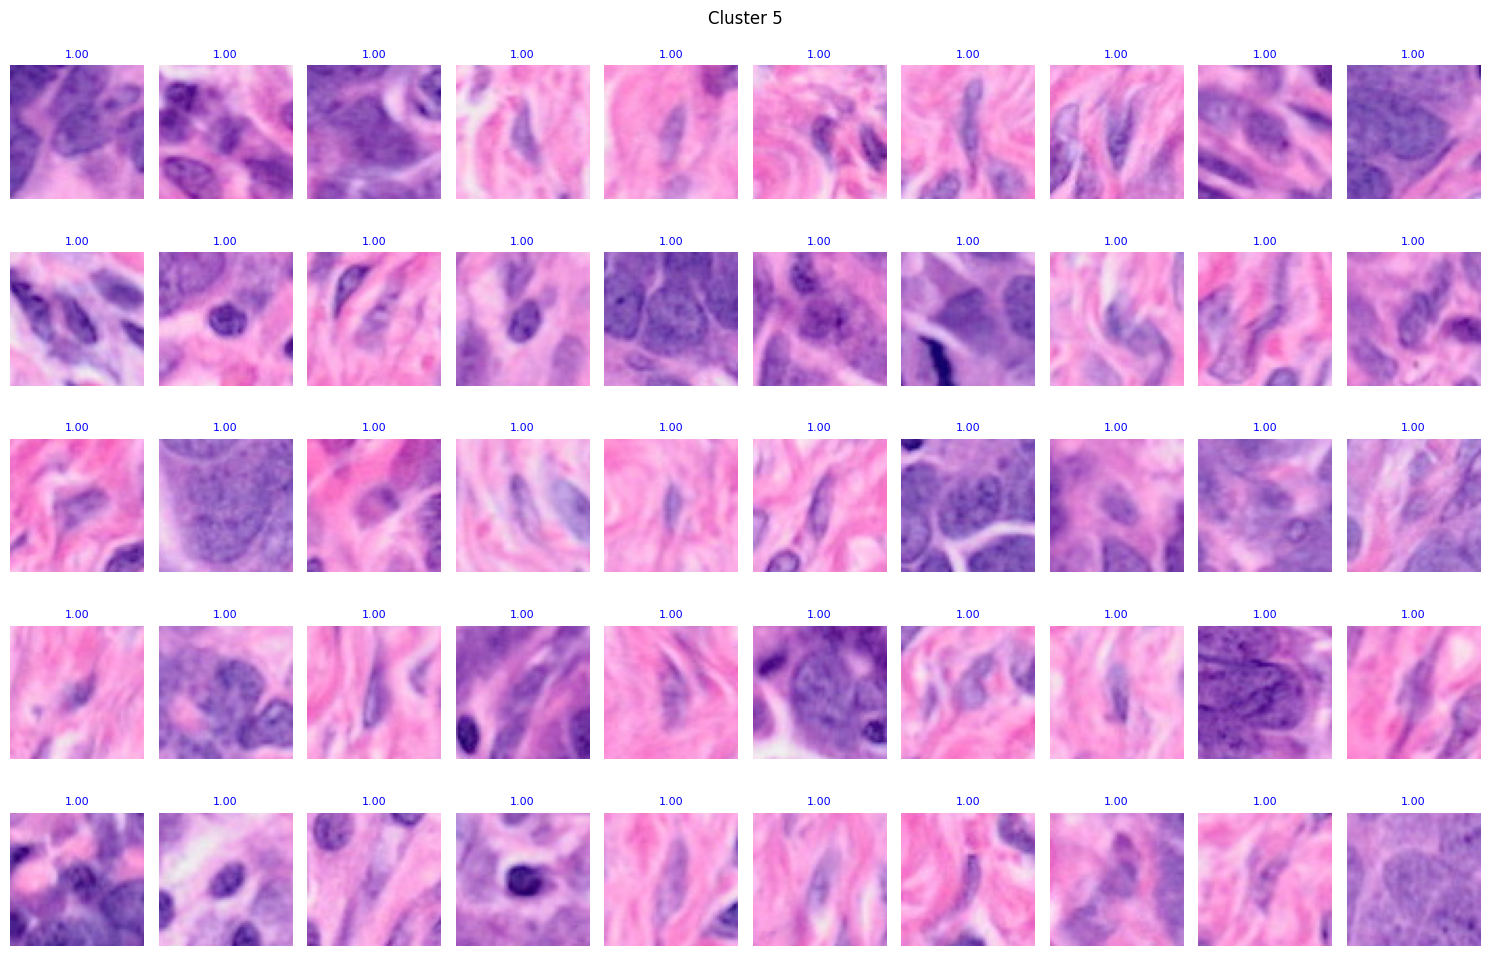

In [121]:
for ct in analyzer.ct_list:
    analyzer.plot_grid_celltype(cell_type=ct, n=50, selection="max", display=True)

Randomly selected spot_id: 345


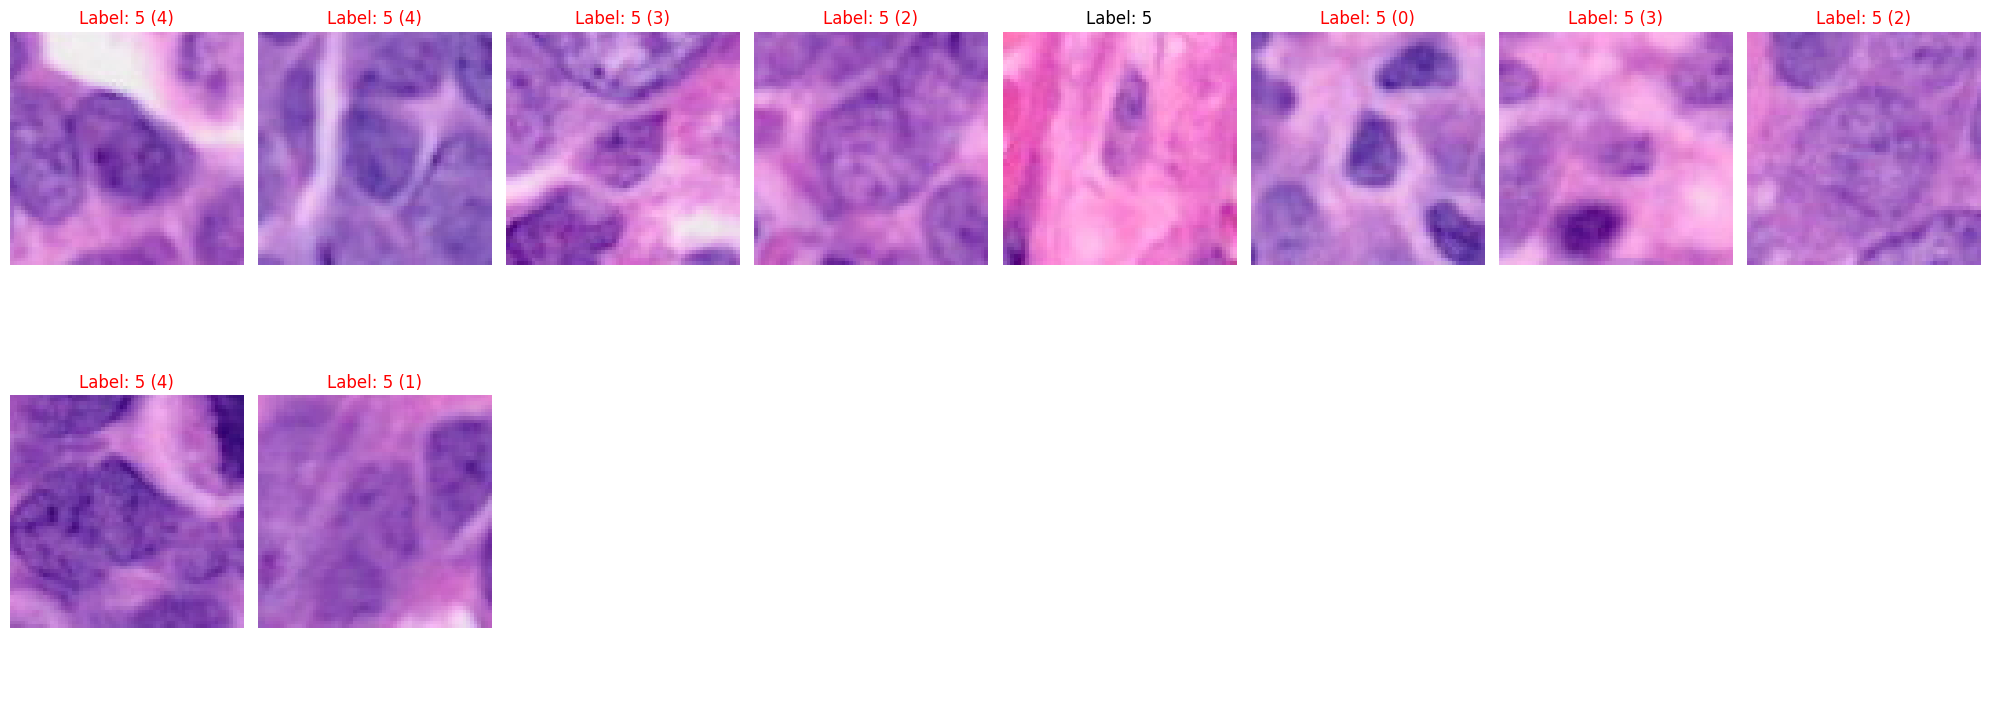

In [11]:
analyzer.plot_mosaic_cells()

In [35]:
analyzer.evaluate_spot_predictions()

{'Spearman Correlation': 0.7182111173806563,
 'Pearson Correlation': 0.7700089660718304,
 'Weighted MSE': 0.0014241130033440855,
 'MSE': 0.01197216005975961,
 'Weighted MAE': 0.010008230400900977,
 'MAE': 0.07074803691546698,
 'R^2 Score': -0.09268101921948241,
 'Balanced Accuracy': 0.5694006244853702,
 'Weighted F1 Score': 0.7815714585334724,
 'Weighted Precision': 0.8971411897811613,
 'Weighted Recall': 0.7138769670958511}

In [36]:
perf = analyzer.evaluate_cell_predictions()

In [37]:
perf

{'Global Accuracy': 0.6570833333333334,
 'Balanced Accuracy': 0.6570833333333334,
 'Weighted F1 Score': 0.6316209587730329,
 'F1 Score (Per Class)': {'Cluster 0': 0.6384689610807334,
  'Cluster 1': 0.6733153638814016,
  'Cluster 2': 0.8264506011500261,
  'Cluster 3': 0.8222755129229949,
  'Cluster 4': 0.829215313603041,
  'Cluster 5': 0.0},
 'Weighted Precision': 0.6423920370211033,
 'Precision (Per Class)': {'Cluster 0': 0.47060218112849694,
  'Cluster 1': 0.7304093567251462,
  'Cluster 2': 0.8658269441401971,
  'Cluster 3': 0.8802053622361665,
  'Cluster 4': 0.9073083778966132,
  'Cluster 5': 0.0},
 'Weighted Recall': 0.6570833333333334,
 'Recall (Per Class)': {'Cluster 0': 0.9925,
  'Cluster 1': 0.6245,
  'Cluster 2': 0.7905,
  'Cluster 3': 0.7715,
  'Cluster 4': 0.7635,
  'Cluster 5': 0.0},
 'Confusion Matrix': array([[1985,    0,    0,   15,    0,    0],
        [   1, 1249,  229,   50,   60,  411],
        [   0,  256, 1581,    7,    8,  148],
        [ 272,   79,    4, 1543,   8

In [38]:
pd.DataFrame(perf["Confusion Matrix"], index=analyzer.ct_list, columns=analyzer.ct_list)

Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4  Cluster 5
Cluster 0       1985          0          0         15          0          0
Cluster 1          1       1249        229         50         60        411
Cluster 2          0        256       1581          7          8        148
Cluster 3        272         79          4       1543         86         16
Cluster 4          2        126         12         98       1527        235
Cluster 5       1958          0          0         40          2          0

In [40]:
perf["Confusion Matrix"].sum(axis=0)

array([4218, 1710, 1826, 1753, 1683,  810])